<a href="https://colab.research.google.com/github/Tarheen-Fatima/Graph_Neural_Network_Using_Squirrel_Dataset/blob/main/Graph_Neural_Network_Using_Squirrel_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 655.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.3 MB/s eta 0:00:00


In [ ]:
from torch_geometric.datasets import WikipediaNetwork
dataset = WikipediaNetwork(root='data/WikipediaNetwork', name='Squirrel')
data = dataset[0]
print(data)

Processing...


Data(x=[5201, 2089], edge_index=[2, 217073], y=[5201], train_mask=[5201, 10], val_mask=[5201, 10], test_mask=[5201, 10])


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location)


In [ ]:
num_classes = len(set(data.y.numpy()))
print(f'Number of classes: {num_classes}')

Number of classes: 5


k=1, Loss: 1.679286003112793, Accuracy: 0.20421958213846783, Nodes: 4882, Edges: 9855910
k=2, Loss: 1.8928406238555908, Accuracy: 0.2361736993035641, Nodes: 4882, Edges: 67780068
k=3, Loss: 1.8712327480316162, Accuracy: 0.2279803359278984, Nodes: 4882, Edges: 140502858


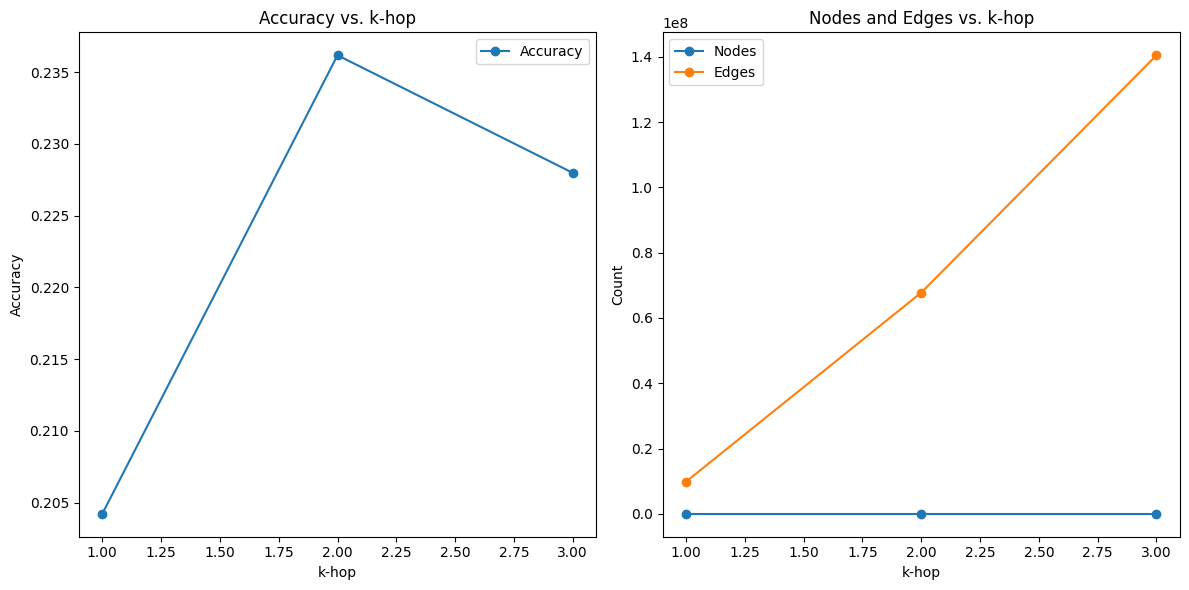

In [ ]:
import torch
import torch.optim as optim
import torch_geometric
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph
import torch.nn as nn
import torch_geometric.nn as pyg_nn

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Instantiate the model, optimizer, and loss function
model = GCN(in_channels=data.num_node_features, hidden_channels=64, out_channels=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Precompute k-hop neighborhoods and filter nodes by degree
def precompute_k_hop_neighbors(data, k, min_degree):
    edge_index = data.edge_index
    filtered_nodes = set()
    total_edges = 0

    for node in range(data.num_nodes):
        subset, edge_index_khop, _, _ = k_hop_subgraph(node, k, edge_index, relabel_nodes=False)

        # Compute the degrees of nodes in the subset from the original graph
        degrees = torch_geometric.utils.degree(edge_index[0], num_nodes=data.num_nodes)

        # Filter nodes in the subset based on degree
        valid_nodes = subset[degrees[subset] >= min_degree]
        filtered_nodes.update(valid_nodes.tolist())

        # Accumulate the number of edges in this k-hop neighborhood
        total_edges += edge_index_khop.size(1) // 2

    filtered_nodes = list(filtered_nodes)
    return filtered_nodes, total_edges

# Function to train and evaluate GNN model and display nodes and edges
def train_and_evaluate_k_hop(data, k, min_degree):
    filtered_nodes, total_edges = precompute_k_hop_neighbors(data, k, min_degree)
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[filtered_nodes] = True
    data.train_mask = train_mask

    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        correct = (pred[data.train_mask] == data.y[data.train_mask]).sum().item()
        accuracy = correct / data.train_mask.sum().item()

    return loss.item(), accuracy, len(filtered_nodes), total_edges

# Train and evaluate for different k-hop values and display node/edge count
k_values = [1, 2, 3]
min_degree = 2
losses = []
accuracies = []
nodes_list = []
edges_list = []

for k in k_values:
    loss, accuracy, num_nodes, num_edges = train_and_evaluate_k_hop(data, k, min_degree)
    losses.append(loss)
    accuracies.append(accuracy)
    nodes_list.append(num_nodes)
    edges_list.append(num_edges)
    print(f'k={k}, Loss: {loss}, Accuracy: {accuracy}, Nodes: {num_nodes}, Edges: {num_edges}')

# Plot the results for Accuracy, Nodes, and Edges
plt.figure(figsize=(12, 6))

# Plot Accuracy vs. k-hop
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.xlabel('k-hop')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k-hop')
plt.legend()

# Plot Nodes and Edges vs. k-hop
plt.subplot(1, 2, 2)
plt.plot(k_values, nodes_list, marker='o', label='Nodes')
plt.plot(k_values, edges_list, marker='o', label='Edges')
plt.xlabel('k-hop')
plt.ylabel('Count')
plt.title('Nodes and Edges vs. k-hop')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), 'gnn_model.pth')


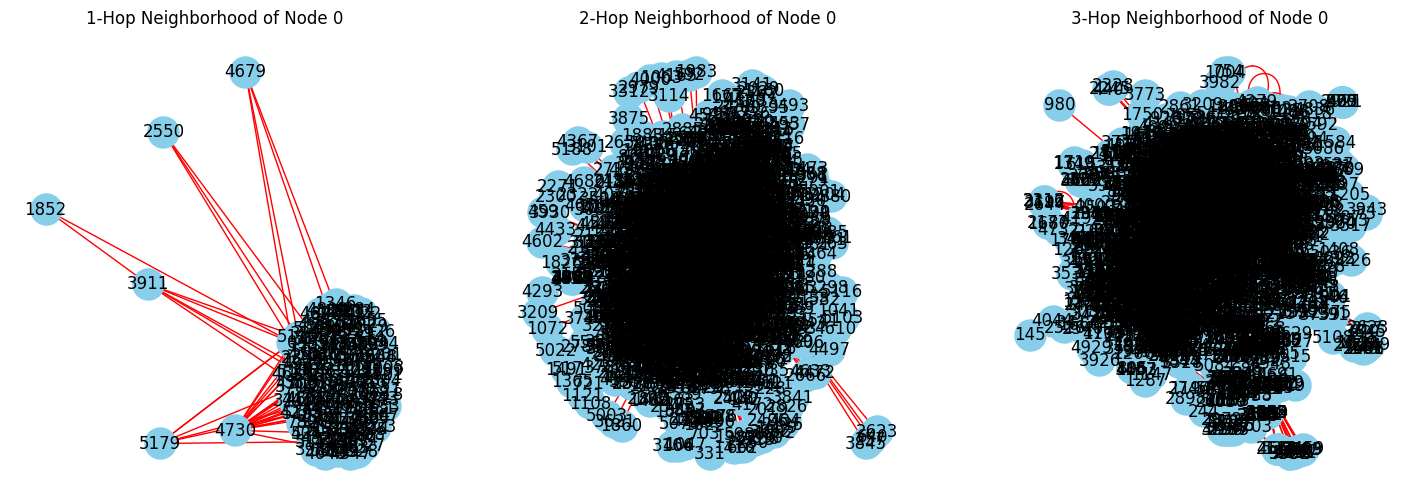

In [ ]:
import torch
import torch.optim as optim
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, k_hop_subgraph
import torch.nn as nn
import torch_geometric.nn as pyg_nn

# Define the GNN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Function to visualize k-hop subgraph for a given k
def visualize_k_hop(data, node_idx, k, ax):
    G = to_networkx(data, to_undirected=True)

    # Extract the k-hop neighborhood
    k_hop_subgraph = nx.ego_graph(G, node_idx, radius=k)

    # Draw the subgraph
    pos = nx.spring_layout(k_hop_subgraph)
    nx.draw(k_hop_subgraph, pos, with_labels=True, node_color='skyblue', edge_color='red', node_size=500, ax=ax)
    ax.set_title(f'{k}-Hop Neighborhood of Node {node_idx}')

# Instantiate the model
model = GCN(in_channels=data.num_node_features, hidden_channels=64, out_channels=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Visualize k-hop subgraphs for a range of k-values
k_values = [1, 2, 3]
node_idx = 0

fig, axs = plt.subplots(1, len(k_values), figsize=(18, 6))

# Loop over each value of k and visualize the corresponding k-hop subgraph
for i, k in enumerate(k_values):
    visualize_k_hop(data, node_idx, k, axs[i])

plt.show()

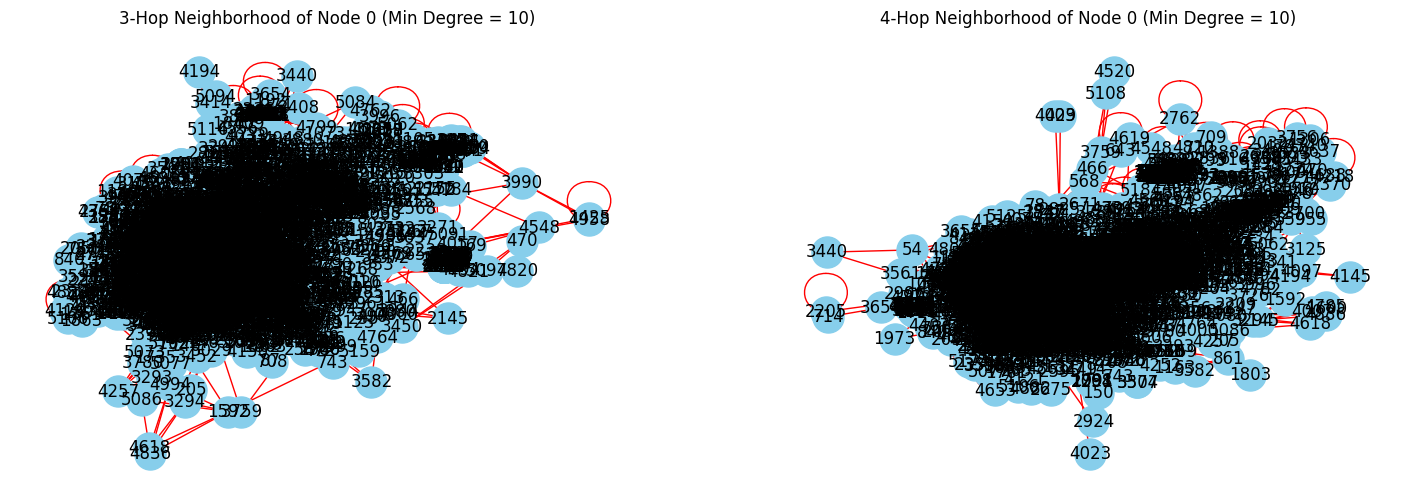

In [ ]:
import torch
import torch.optim as optim
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch.nn as nn
import torch_geometric.nn as pyg_nn

# Define the GNN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Function to visualize k-hop subgraph with minimum degree filtering
def visualize_k_hop_min_degree(data, node_idx, k, min_degree, ax):
    G = to_networkx(data, to_undirected=True)

    # Extract the k-hop neighborhood
    k_hop_subgraph = nx.ego_graph(G, node_idx, radius=k)

    # Filter nodes by degree
    filtered_nodes = [n for n in k_hop_subgraph.nodes if k_hop_subgraph.degree[n] >= min_degree]
    filtered_subgraph = k_hop_subgraph.subgraph(filtered_nodes)

    # Draw the subgraph
    pos = nx.spring_layout(filtered_subgraph)
    nx.draw(filtered_subgraph, pos, with_labels=True, node_color='skyblue', edge_color='red', node_size=500, ax=ax)
    ax.set_title(f'{k}-Hop Neighborhood of Node {node_idx} (Min Degree = {min_degree})')

# Instantiate the model
model = GCN(in_channels=data.num_node_features, hidden_channels=64, out_channels=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Visualize k-hop subgraphs with degree filtering for a range of k-values
k_values = [3,4]
min_degree = 10
node_idx = 0

fig, axs = plt.subplots(1, len(k_values), figsize=(18, 6))

# Loop over each value of k and visualize the corresponding k-hop subgraph with min degree filtering
for i, k in enumerate(k_values):
    visualize_k_hop_min_degree(data, node_idx, k, min_degree, axs[i])

plt.show()